# Customer Satisfaction Prediction

## Download Dataset

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("jahnavipaliwal/customer-feedback-and-satisfaction")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/jahnavipaliwal/customer-feedback-and-satisfaction/versions/1


In [2]:
!ls /root/.cache/kagglehub/datasets/jahnavipaliwal/customer-feedback-and-satisfaction/versions/1

customer_feedback_satisfaction.csv


## Load Dependencies

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


### Load Dataset

In [4]:
df = pd.read_csv(path + "/customer_feedback_satisfaction.csv")
df.head()

,CustomerID,Age,Gender,Country,Income,ProductQuality,ServiceQuality,PurchaseFrequency,FeedbackScore,LoyaltyLevel,SatisfactionScore
0,1,56,Male,UK,83094,5,8,5,Low,Bronze,100.0
1,2,69,Male,UK,86860,10,2,8,Medium,Gold,100.0
2,3,46,Female,USA,60173,8,10,18,Medium,Silver,100.0
3,4,32,Female,UK,73884,7,10,16,Low,Gold,100.0
4,5,60,Male,UK,97546,6,4,13,Low,Bronze,82.0


## Encode columns

In [5]:
df_original = df.copy()

le = LabelEncoder()

columns_to_encode = ["Gender", "Country", "FeedbackScore", "LoyaltyLevel"]

for column in columns_to_encode:
    df[column] = le.fit_transform(df[column])


## Analyse Correlation

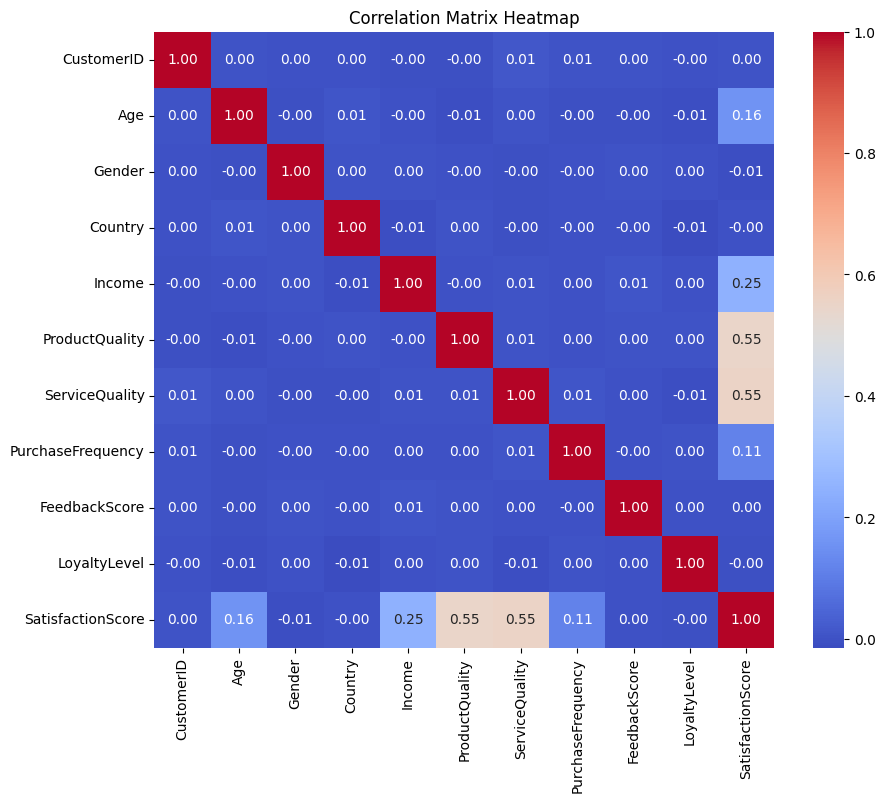

In [6]:
# Calculate the correlation matrix
corr = df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Get important variables to identify SatisfactionScore

In [7]:
corr_2 = corr["SatisfactionScore"].sort_values(ascending=False).head(6)
corr_2.drop("SatisfactionScore", inplace=True)
corr_2.keys()

Index(['ServiceQuality', 'ProductQuality', 'Income', 'Age',
       'PurchaseFrequency'],
      dtype='object')

### Define features

In [8]:
df_important_variables_wr_SC = df[corr_2.keys()]
df_important_variables_wr_SC.head()

,ServiceQuality,ProductQuality,Income,Age,PurchaseFrequency
0,8,5,83094,56,5
1,2,10,86860,69,8
2,10,8,60173,46,18
3,10,7,73884,32,16
4,4,6,97546,60,13


### Scale Features

In [9]:
scaler = StandardScaler()

df_important_variables_wr_SC = pd.DataFrame(scaler.fit_transform(df_important_variables_wr_SC), columns=df_important_variables_wr_SC.columns)

df_important_variables_wr_SC.head()

,ServiceQuality,ProductQuality,Income,Age,PurchaseFrequency
0,0.871845,-0.172196,0.308653,0.835071,-0.945943
1,-1.214549,1.568051,0.453636,1.703326,-0.425611
2,1.567310,0.871952,-0.573759,0.167182,1.308830
3,1.567310,0.523903,-0.045913,-0.767862,0.961942
4,-0.519084,0.175854,0.865025,1.102227,0.441609


### Define Target

In [10]:
target = df["SatisfactionScore"]

### Train Test Val Split

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df_important_variables_wr_SC, target, test_size=0.2, random_state=42)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Pytorch Model

### Define Best Loss to later save best model

In [12]:
best_loss = 1000

#### Convert Train Test Val into Tensors

In [13]:
# Convert pandas dataframes to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

#### Create DataLoader

In [14]:
# Create DataLoader for training
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

#### Define Model
Our model will have an input layer, two hidden laers and an output layer

In [23]:
# Define the linear regression model
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear1 = nn.Linear(input_dim, 64)
        self.linear2 = nn.Linear(64, 32)
        self.linear3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = torch.relu(self.linear1(x))
        x = torch.relu(self.linear2(x))
        x = self.linear3(x)
        return x

#### Initialize Model, loss function and Optimizer

In [24]:
input_dim = X_train.shape[1]
model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

#### Train the model

In [25]:
# Training the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        y_val_pred = model(X_val_tensor)
        val_loss = criterion(y_val_pred, y_val_tensor)
# Save the best model according to validation loss
    if val_loss.item() < best_loss:       
        best_loss = val_loss.item()
        print(f'Best Loss on Validation: {val_loss.item():.4f}')
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved at epoch {epoch+1}')
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [10/100], Loss: 154.4267
Epoch [20/100], Loss: 22.7980
Best Loss on Validation: 58.1004
Epoch [30/100], Loss: 60.9852
Epoch [40/100], Loss: 280.1648
Epoch [50/100], Loss: 65.3223
Epoch [60/100], Loss: 44.7474
Epoch [70/100], Loss: 91.4783
Epoch [80/100], Loss: 43.7887
Epoch [90/100], Loss: 16.0586
Epoch [100/100], Loss: 7.6799


### Load Best Model

In [26]:
model = LinearRegressionModel(input_dim)
model.load_state_dict(torch.load('best_model.pth', weights_only=True))


<All keys matched successfully>

#### Evaluate the model

In [27]:
# Evaluate the model on validation and test data
model.eval()

LinearRegressionModel(
  (linear1): Linear(in_features=5, out_features=64, bias=True)
  (linear2): Linear(in_features=64, out_features=32, bias=True)
  (linear3): Linear(in_features=32, out_features=1, bias=True)
)

#### Make predictions

In [28]:
with torch.no_grad():
    y_test_pred = model(X_test_tensor)

#### Print model stadistics

In [29]:
# Calculate MAE and MSE
mae = mean_absolute_error(y_test_tensor, y_test_pred)
mse = mean_squared_error(y_test_tensor, y_test_pred)

print(f'Mean Absolute Error (MAE): {mae:.4f}')
print(f'Mean Squared Error (MSE): {mse:.4f}')

# Calculate R² score for the test set
r2 = r2_score(y_test_tensor, y_test_pred)
print(f'R² Score: {r2:.4f}')

Mean Absolute Error (MAE): 5.3503
Mean Squared Error (MSE): 57.7828
R² Score: 0.7921


#### Convert to Numpy y_test and y_pred

In [30]:
# Convert tensors to numpy arrays for plotting
y_test_pred_np = y_test_pred.numpy()
y_test_tensor_np = y_test_tensor.numpy()

# Plot

In [43]:
# Create a DataFrame for seaborn
df_plot = pd.DataFrame({
    'y_test_pred': y_test_pred_np.flatten(),
    'y_test_tensor': y_test_tensor_np.flatten()
})

sns.set_theme(style="darkgrid")

df_plot['y_test_pred'] = df_plot['y_test_pred'].astype(int)
df_plot['y_test_tensor'] = df_plot['y_test_tensor'].astype(int)



In [45]:
df_plot['diff'] = df_plot['y_test_pred'] - df_plot['y_test_tensor']
df_plot.head()

,y_test_pred,y_test_tensor,diff
0,96,81,15
1,79,83,-4
2,98,100,-2
3,100,100,0
4,99,100,-1


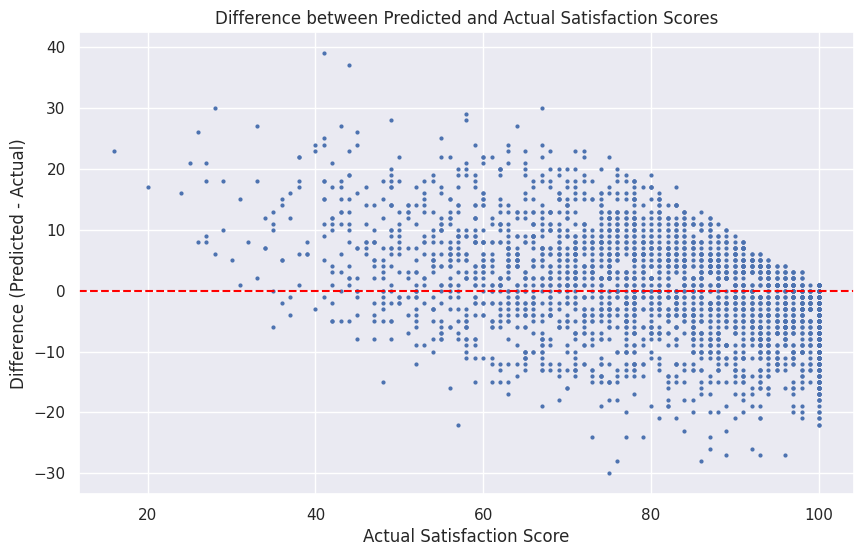

In [58]:
# Plot the difference between y_test_pred and y_test_tensor
plt.figure(figsize=(10, 6))
plt.plot(df_plot['y_test_tensor'], df_plot['diff'], 'o', markersize=2)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Actual Satisfaction Score')
plt.ylabel('Difference (Predicted - Actual)')
plt.title('Difference between Predicted and Actual Satisfaction Scores')
plt.show()

### Conclusion

The notebook demonstrates a comprehensive approach to predicting customer satisfaction scores using a linear regression model implemented in PyTorch. The process includes data preprocessing, feature scaling, model training, and evaluation. The model achieved a good performance with a high R2 score, indicating its effectiveness in predicting customer satisfaction based on the selected features.